In [8]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np
import random
import torch
import bayesflow as bf
import matplotlib.pyplot as plt
import pandas as pd

from data_utils import DataGeneratorMulti, sample_beta, constant_n
from networks import MultiBayesEvidenceNetwork
from metrics import multimodel_accuracy
from losses import multimodel_exponential_loss

In [9]:
print(f"Using Keras backend: {keras.backend.backend()}")

print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

np.random.seed(17)
random.seed(17)
torch.manual_seed(17)

Using Keras backend: torch
CUDA available: True
GPU device: NVIDIA GeForce RTX 4080 Laptop GPU


### Wrapper

In [10]:
def train_test(model, name, train_loader, val_loader, n_tests, sample_funcs, n_norm_factor, epochs):

    print(f"\n--- Training: {name} ---")
    
    # Train
    with torch.enable_grad():  # If using PyTorch; ignore if using pure Keras
        history = model.fit(
            train_loader,
            validation_data=val_loader,
            epochs=epochs,
            verbose=1
        )
    
    # Test
    print(f"\n--- Testing: {name} ---")
    test_results = {}

    for n_test in n_tests:
        print(f"\nSequence length n={n_test}:")
        acc_list = []

        # Loop over all models
        for idx, func in enumerate(sample_funcs):
            # Generate a batch of samples for this model
            X_test = func(100, n_test)  # e.g., 100 samples per model
            y_test = np.full((X_test.shape[0], 1), idx, dtype=np.int32)
            n_batch = np.full((X_test.shape[0], 1), n_test / n_norm_factor, dtype=np.float32)

            # Predict
            f_x = model.predict([X_test[:, :, None], n_batch], verbose=0)

            # Compute accuracy using generalized metric
            acc = multimodel_accuracy(y_test, f_x) # convert Keras tensor to scalar
            acc_list.append(acc)
            print(f" Model {idx} accuracy: {acc*100:.2f}%")

        test_results[f'n_{n_test}'] = {f'acc_{i}': acc for i, acc in enumerate(acc_list)}
    
    return model, history, test_results

# Results

In [11]:
BATCH_SIZE = 128
TRAIN_BATCHES = 256
VAL_BATCHES = 8
EPOCHS = 20
N_NORM_FACTOR = 10
N_TESTS = [5, 10, 25]

beta_priors = [
    lambda s, n=30: sample_beta(s, n, alpha=2, beta=3),   # mean ≈ 0.4
    lambda s, n=30: sample_beta(s, n, alpha=3, beta=4),   # mean ≈ 0.43
    lambda s, n=30: sample_beta(s, n, alpha=4, beta=5),   # mean ≈ 0.44
    lambda s, n=30: sample_beta(s, n, alpha=5, beta=6),   # mean ≈ 0.45
]

train_loader = DataGeneratorMulti(
    batches_per_epoch=TRAIN_BATCHES,
    sample_funcs=beta_priors,
    n_generator=lambda : constant_n(n=6),
    batch_size=BATCH_SIZE,
    n_norm=N_NORM_FACTOR
)

# Validation loader
val_loader = DataGeneratorMulti(
    batches_per_epoch=VAL_BATCHES,
    sample_funcs=beta_priors,
    n_generator=constant_n,
    batch_size=BATCH_SIZE,
    n_norm=N_NORM_FACTOR
)

In [12]:
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=EPOCHS * len(train_loader)
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model_instance = MultiBayesEvidenceNetwork(len(beta_priors))

model_instance.compile(
    optimizer=optimizer,
    loss=multimodel_exponential_loss,
    metrics=[multimodel_accuracy]
)

# train + test
trained_model, history, test_results = train_test(
    model=model_instance,
    name="Multi Model Testing",
    train_loader=train_loader,
    val_loader=val_loader,
    sample_funcs=beta_priors,
    n_tests=N_TESTS,
    n_norm_factor=N_NORM_FACTOR,
    epochs=EPOCHS
)


--- Training: Multi Model Testing ---
Epoch 1/20
244/256 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 1.9542 - multimodel_accuracy: 0.1554

KeyboardInterrupt: 


Loss History


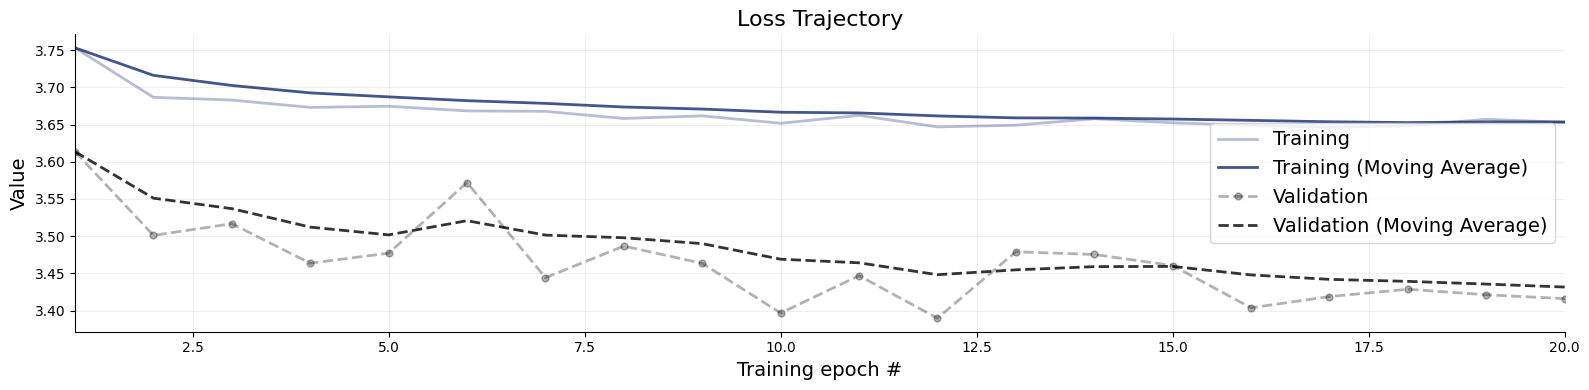

In [7]:
print(f"\nLoss History")
bf.diagnostics.plots.loss(history=history)
plt.show()

In [17]:
from scipy.stats import beta
import numpy as np

def calculate_true_log_evidence(X, alpha, beta_param):
    """
    X: shape (num_samples, seq_len), values in [0,1]
    alpha, beta_param: parameters of the Beta distribution
    """
    # Compute log PDF for each element
    log_pdf = beta.logpdf(X, alpha, beta_param)  # shape: (num_samples, seq_len)

    # Sum over sequence to get total log-likelihood per sample
    log_evidence = np.sum(log_pdf, axis=1)  # shape: (num_samples,)
    return log_evidence

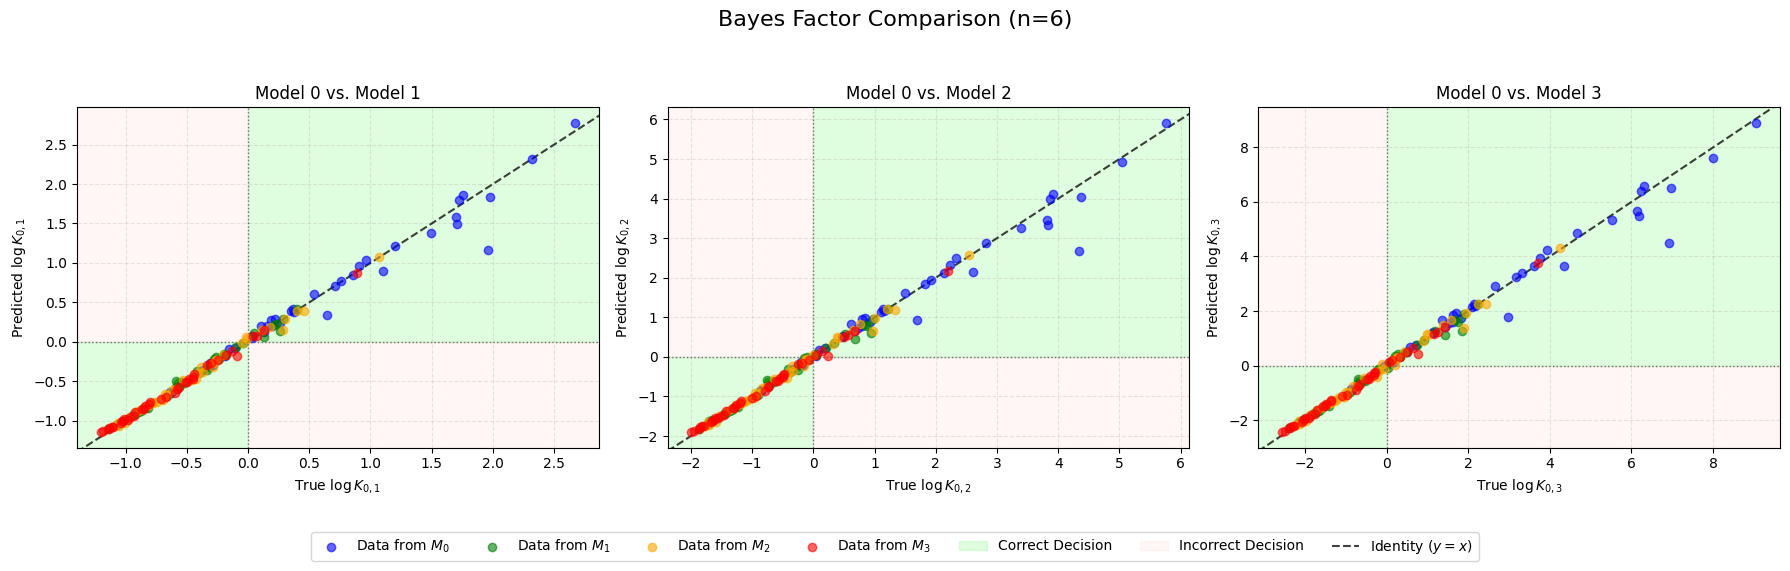

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def check_bayes_factors(): 

    model_params = [
        (2, 3),   # Model 0: Beta(1, 1)
        (3, 4), # Model 1: Beta(10, 10)
        (4, 5),  # Model 2: Beta(1, 10)
        (5, 6)   # Model 3: Beta(10, 1)
    ]
    n_models = len(model_params)

    N_SAMPLES = 40 
    N_SEQ = 6    


    fig, axes = plt.subplots(1, n_models - 1, figsize=(18, 5))
    if n_models == 2: 
        axes = [axes]
   
    colors = ['blue', 'green', 'orange', 'red']

    for true_model_idx in range(n_models):
        data_sampler = beta_priors[true_model_idx]
        X_test = data_sampler(N_SAMPLES, N_SEQ)

        n_batch = np.full((N_SAMPLES, 1), N_SEQ / N_NORM_FACTOR, dtype=np.float32)
        f_x_predicted = trained_model.predict([X_test[:, :, None], n_batch], verbose=0)

        log_evidence_true = np.zeros((N_SAMPLES, n_models))
        for i, (alpha, beta) in enumerate(model_params):
            log_evidence_true[:, i] = calculate_true_log_evidence(X_test, alpha, beta)

        log_bf_true = log_evidence_true[:, 0:1] - log_evidence_true[:, 1:]
        log_bf_predicted = f_x_predicted 

 
        for i, ax in enumerate(axes):
            model_k_idx = i + 1 
            
            ax.scatter(log_bf_true[:, i], log_bf_predicted[:, i], 
                       alpha=0.6, 
                       color=colors[true_model_idx], 
                       label=f"Data from $M_{true_model_idx}$" if i == 0 else "_nolegend_",
                       zorder=3)

    for i, ax in enumerate(axes):
        model_k_idx = i + 1
        
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        x_neg = np.linspace(xlim[0], 0, 10)
        x_pos = np.linspace(0, xlim[1], 10)
        
        ax.fill_between(x_pos, 0, ylim[1], color='palegreen', alpha=0.3, zorder=1,
                        label="Correct Decision" if i == 0 else "_nolegend_")
        
        ax.fill_between(x_neg, ylim[0], 0, color='palegreen', alpha=0.3, zorder=1,
                        label="_nolegend_")
        
        ax.fill_between(x_neg, 0, ylim[1], color='mistyrose', alpha=0.3, zorder=1,
                        label="Incorrect Decision" if i == 0 else "_nolegend_")
        
        ax.fill_between(x_pos, ylim[0], 0, color='mistyrose', alpha=0.3, zorder=1,
                        label="_nolegend_")
        
        ax.axhline(0, color='k', linestyle=':', linewidth=1, alpha=0.5, zorder=2)
        ax.axvline(0, color='k', linestyle=':', linewidth=1, alpha=0.5, zorder=2)

        lims = [
            np.min([xlim, ylim]),
            np.max([xlim, ylim]),
        ]
        ax.plot(lims, lims, 'k--', alpha=0.75, zorder=2, label="Identity ($y=x$)")
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        ax.set_xlabel(f"True $\log K_{{0,{model_k_idx}}}$")
        ax.set_ylabel(f"Predicted $\log K_{{0,{model_k_idx}}}$")
        ax.set_title(f"Model 0 vs. Model {model_k_idx}")
        ax.grid(True, linestyle='--', alpha=0.3)

    handles, labels = axes[0].get_legend_handles_labels()
    n_legend_cols = n_models + 3 
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=n_legend_cols)

    plt.suptitle(f"Bayes Factor Comparison (n={N_SEQ})", fontsize=16, y=1.05)
    plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make room for legend
    plt.show()

# ---
# Call the function
check_bayes_factors()